In [256]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import math
import numpy.random as rn
import matplotlib as mpl
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import numpy as np

In [110]:
!pip install filterpy

  Created wheel for filterpy: filename=filterpy-1.4.5-py3-none-any.whl size=110454 sha256=cc91d896b4832f3d4148e442568436452afda7fe70a201ca5cbe4de62005b3f6
  Stored in directory: c:\users\91709\appdata\local\pip\cache\wheels\ce\e0\ee\a2b3c5caab3418c1ccd8c4de573d4cbe13315d7e8b0a55fbc2
Successfully built filterpy


In [221]:
from filterpy.kalman import predict,update,KalmanFilter
from filterpy.common import Q_discrete_white_noise

In [18]:
def gaussian(mu,var,data):
    norm_const = 1/np.sqrt(2*np.pi*var)
    exponential = np.exp(-0.5*((data-mu)**2/var))
    return (norm_const)*(exponential)

In [4]:
def predict(mu1,var1,mu2,var2):
    new_mu = mu1+mu2
    new_var = var1+var2
    return [new_mu,new_var]

In [11]:
def update(mu1,var1,mu2,var2):
    new_mu = ((var2*mu1)+(var1*mu2))/(var1+var2)
    new_var = 1/((1/var1)+(1/var2))
    return [new_mu,new_var]

In [46]:
measurements = [5., 6., 7., 9., 11.,13.,15.,18.,21.,24.,27.]
motions = [1., 1., 2., 2., 2.,2.,3.,3.,3.,3.,3.]

measurement_var = 3
motion_var = 1.5
mean = 0
var = 10000

for i in range(len(measurements)):
    obs,motion = measurements[i],motions[i]
    mean,var = update(mean,var,obs,measurement_var)
    print("Updated mean and Variance: {} , {}".format(mean,var))
    mean,var = predict(mean,var,motion,motion_var)
    print("Predicted mean and Variance: {} , {}".format(mean,var))
print("\n")
print("Final Estimated Mean and Variance from Kalman Filter: {} , {}".format(mean,var))

Updated mean and Variance: 4.99850044986504 , 2.9991002699190243
Predicted mean and Variance: 5.99850044986504 , 4.499100269919024
Updated mean and Variance: 5.999400107980564 , 1.7998560259153353
Predicted mean and Variance: 6.999400107980564 , 3.2998560259153353
Updated mean and Variance: 6.999714330605191 , 1.5713959234977362
Predicted mean and Variance: 8.99971433060519 , 3.071395923497736
Updated mean and Variance: 8.999858844951765 , 1.5176390877149233
Predicted mean and Variance: 10.999858844951765 , 3.0176390877149233
Updated mean and Variance: 10.99992962935488 , 1.5043968458704013
Predicted mean and Variance: 12.99992962935488 , 3.004396845870401
Updated mean and Variance: 12.999964840442631 , 1.5010984065468855
Predicted mean and Variance: 14.999964840442631 , 3.0010984065468858
Updated mean and Variance: 14.999982423439018 , 1.5002745513752167
Predicted mean and Variance: 17.999982423439018 , 3.0002745513752167
Updated mean and Variance: 17.99999121212163 , 1.50006863470317

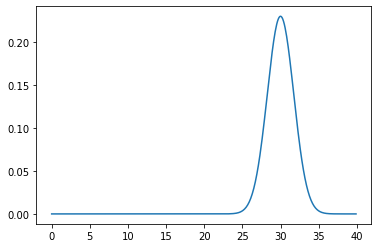

In [51]:
## Print out and display the final, resulting Gaussian 
# set the parameters equal to the output of the Kalman filter result
mu = mean
sigma2 = var

# define a range of x values
x_axis = np.arange(0, 40, 0.1)

# create a corresponding list of gaussian values
g = []
for x in x_axis:
    g.append(gaussian(mu, sigma2, x))

# plot the result 
plt.plot(x_axis, g)

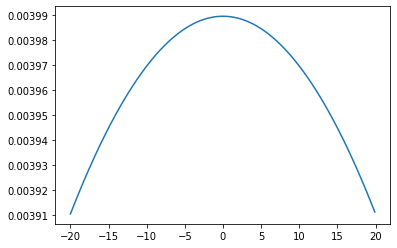

In [52]:
mu = 0
sigma2 = 10000

# define a range of x values
x_axis = np.arange(-20, 20, 0.1)

# create a corresponding list of gaussian values
g = []
for x in x_axis:
    g.append(gaussian(mu, sigma2, x))

# plot the result 
plt.plot(x_axis, g)

In [68]:
def multivariate_gaussian(data,mean,covar):
    data = np.array(data,copy=False,ndmin=1).flatten()
    mean = np.array(data,copy=False,ndmin=1).flatten()
    mean_vec_length = len(mean)
    covar = check_covariance(covar,mean_vec_length)
    
    norm_coeff = mean_vec_length*math.log(2*math.pi) + np.linalg.slogdet(covar)[1]
    diff =data-mean
    
    if(sc.sparse.issparse(covar)):
        numerator = sc.sparse.linalg.spsolve(covar,diff).T.dot(diff)
    else:
        numerator = np.linalg.solve(covar,diff).T.dot(diff)
        
    return math.exp(-0.5*(norm_coeff+numerator))

In [53]:
def check_covariance(covar,mu_len):
    if(np.isscalar(covar)):
        if(covar<0):
            raise ValueError('Covariance must be greater than 0')
        return np.eye(mu_len)*covar
    covar = np.atleast_2d(covar)
    try:
        np.linalg.cholesky(covar)
    except:
        raise ValueError('Covariance must be positive Definite')
    return covar

In [69]:
# x - data, mu - mean vector, P - covariance Matrix. 
x = [2.5, 7.3]
mu = [2.0, 7.0]
P = [[8., 0.], 
     [0., 3.]]
%precision 8
multivariate_gaussian(x, mu, P)

0.03248737

In [71]:
height = [60, 62, 63, 65, 65.1, 68, 69, 70, 72, 74]
weight = [95, 120, 127, 119, 151, 143, 173, 171, 180, 210]
cov_hw = np.cov(np.vstack((height, weight)), bias=1)
cov_hw

array([[  18.5249,  135.701 ],
       [ 135.701 , 1092.29  ]])

In [72]:
from scipy.stats import pearsonr
pearsonr(height, weight)[0]

0.9539731096080194

In [73]:
def weighted_avg_gaussians(mu1,cov1,mu2,cov2):
    mu1,mu2 = np.asarray(mu1),np.asarray(mu2)
    cov1,cov2 = np.asarray(cov1),np.asarray(cov2)
    cov_inv = np.linalg.inv(cov1+cov2)
    
    cov_mean = np.dot(cov1,cov_inv).dot(cov2)
    mu_mean = (np.dot(cov2,cov_inv).dot(mu1)+np.dot(cov1,cov_inv).dot(mu2))
    
    return mu_mean,cov_mean

In [75]:
mu = [0.3, 5., 10.]
C = np.array([[1.0, .03, .2],
              [.03,  4.0, .0],
              [.2,  .0, 16.1]])

sample = np.random.multivariate_normal(mu, C, size=1000)
print(sample)

[[ 1.1139792   2.8386826  10.52299   ]
 [-1.2388811   4.03048469  8.44023222]
 [-0.08895158  3.27847063  7.23308878]
 ...
 [ 0.78687324  6.01692892  9.80738765]
 [-0.11249459  5.54952289 12.10925302]
 [ 1.06580144  6.90293626 19.67265792]]


In [237]:
def get_data(data_var,process_var,cnt=1,dt=1):
    pos,vel = 0,1
    data_std = math.sqrt(data_var)
    proc_std = math.sqrt(process_var)
    xs,zs = [],[]
    
    for _ in range(count):
        vel += (rn.randn()*proc_std)
        pos += vel*dt
        xs.append(x)
        zs.append(x + rn.randn()*data_std)
    
    return np.array(xs),np.array(zs)

In [223]:
# F - state Transition Matrix, P - state covariance Matrix, mean - state Mean Vector, B - control Input Matrix, Q - Process 
# Covariance Matrix, K - kalman Gain, y - Residual Gain, z -  Measurement Mean, x- state vector,u- control vector,
# R - Noise Covariance Matrix.

dt = 0.1
mean = np.array([10.0,10.0,4.0,4.0])

P = np.diag([500., 500., 49.,49.])

F = np.array([[1, 0, dt, 0 ],
                [0, 1,  0, dt],
                [0, 0,  1, 0 ],
                [0, 0,  0, 1 ]])
Q = Q_discrete_white_noise(dim=4, dt=1., var=2.35)

R = np.array([[100, 0],
              [0,  70]])
u = 0

H = np.array([[1., 0.,0.,0.],
              [0., 1.,0.,0.]])
print(H.shape,x.reshape(4,1).shape)

(2, 4) (4, 1)


In [224]:
x,P = predict(x=mean,P=P,F=F,Q=Q)
print(x)

[0.4 0.4 4.  4. ]


In [225]:
for i in range(10):
    x, P = predict(x=x, P=P, F=F, Q=Q)
    print('i=',i,'x =', x)

i= 0 x = [0.8 0.8 4.  4. ]
i= 1 x = [1.2 1.2 4.  4. ]
i= 2 x = [1.6 1.6 4.  4. ]
i= 3 x = [2. 2. 4. 4.]
i= 4 x = [2.4 2.4 4.  4. ]
i= 5 x = [2.8 2.8 4.  4. ]
i= 6 x = [3.2 3.2 4.  4. ]
i= 7 x = [3.6 3.6 4.  4. ]
i= 8 x = [4. 4. 4. 4.]
i= 9 x = [4.4 4.4 4.  4. ]


In [226]:
print(P)

[[573.36388889  19.81833333  71.13333333  17.23333333]
 [ 19.81833333 587.725       25.85        79.75      ]
 [ 71.13333333  25.85        74.85        25.85      ]
 [ 17.23333333  79.75        25.85        74.85      ]]


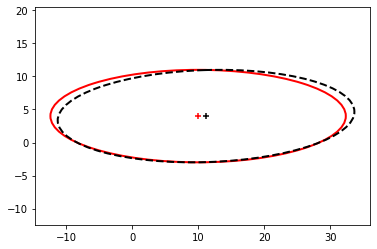

In [291]:
from filterpy.stats import plot_covariance_ellipse

dt = 0.3
F = np.array([[1,dt], [0,1]])
x = np.array([10.0,4.0])
P = np.diag([500,49])
plot_covariance_ellipse(x, P, edgecolor='r')
x, P = predict(x, P, F, Q=0)
plot_covariance_ellipse(x, P, edgecolor='k', ls='dashed')

In [227]:
print(x)

[4.4 4.4 4.  4. ]


In [229]:
z = np.array([[1.],
              [0.8]])
print(z.shape)
x, P = update(x.reshape(4,1), P, z, R, H)
print('x =', x)

(2, 1)
x = [[1.2637911 ]
 [0.99645987]
 [3.47961355]
 [3.46143216]]


In [231]:
pos_tracker = KalmanFilter(dim_x=4, dim_z=2)

In [232]:
print('x = ', dog_filter.x.T)
print('R = ', dog_filter.R)
print('Q = \n', dog_filter.Q)

x =  [[0. 0. 0. 0.]]
R =  [[1. 0.]
 [0. 1.]]
Q = 
 [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


In [233]:
def pos_vel_filter(x=mean,F=F, H=H,P=P, R=R, Q=Q, dt=dt):
    kf = KalmanFilter(dim_x=4, dim_z=2)
    kf.x = np.array([x[0], x[1]]) # location and velocity
    kf.F = F  # state transition matrix
    kf.H = H    # Measurement function
    kf.R *= R                     # measurement uncertainty
    if np.isscalar(P):
        kf.P *= P                 # covariance matrix 
    else:
        kf.P[:] = P               # [:] makes deep copy
    if np.isscalar(Q):
        kf.Q = Q
    else:
        kf.Q[:] = Q
    return kf

In [234]:
kf = pos_vel_filter(x=mean,F=F,H=H,P=P, R=R, Q=Q, dt=dt)

In [235]:
kf

KalmanFilter object
dim_x = 4
dim_z = 2
dim_u = 0
x = [0. 0.]
P = [[45.98543946  0.08943487  5.64532742  1.17990146]
     [ 0.08943487 33.03084714  1.32712403  4.45603023]
     [ 5.64532742  1.32712403 65.83840496 20.88029691]
     [ 1.17990146  4.45603023 20.88029691 64.28994413]]
x_prior = [[0. 0. 0. 0.]].T
P_prior = [[1. 0. 0. 0.]
           [0. 1. 0. 0.]
           [0. 0. 1. 0.]
           [0. 0. 0. 1.]]
x_post = [[0. 0. 0. 0.]].T
P_post = [[1. 0. 0. 0.]
          [0. 1. 0. 0.]
          [0. 0. 1. 0.]
          [0. 0. 0. 1.]]
F = [[1.  0.  0.1 0. ]
     [0.  1.  0.  0.1]
     [0.  0.  1.  0. ]
     [0.  0.  0.  1. ]]
Q = [[0.06527778 0.19583333 0.39166667 0.39166667]
     [0.19583333 0.5875     1.175      1.175     ]
     [0.39166667 1.175      2.35       2.35      ]
     [0.39166667 1.175      2.35       2.35      ]]
R = [[100.   0.]
     [  0.  70.]]
H = [[1. 0. 0. 0.]
     [0. 1. 0. 0.]]
K = [[0. 0.]
     [0. 0.]
     [0. 0.]
     [0. 0.]]
y = [[0. 0.]].T
S = [[0. 0.]
     [0. 0

In [283]:
def plot_track_1(xs, ys=None, dt=None, label='Track', c='k', lw=2, **kwargs):
    if ys is None and dt is not None:
        ys = xs
        xs = np.arange(0, len(ys)*dt, dt)
    if ys is not None:
        return plt.plot(xs, ys, color=c, lw=lw, ls=':', label=label)
    else:
        return plt.plot(xs, color=c, lw=lw, ls=':', label=label)

In [272]:
def plot_measurements(xs, ys=None, dt=None, color='k', lw=1, label='Measurements',
                      lines=False, **kwargs):

    if ys is None and dt is not None:
        ys = xs
        xs = np.arange(0, len(ys)*dt, dt)

    plt.autoscale(tight=False)
    if lines:
        if ys is not None:
            return plt.plot(xs, ys, color=color, lw=lw, ls='--', label=label, **kwargs)
        else:
            return plt.plot(xs, color=color, lw=lw, ls='--', label=label, **kwargs)
    else:
        if ys is not None:
            return plt.scatter(xs, ys, edgecolor=color, facecolor='none',
                        lw=2, label=label, **kwargs)
        else:
            return plt.scatter(range(len(xs)), xs, edgecolor=color, facecolor='none',
                        lw=2, label=label, **kwargs)
    

In [273]:
def plot_filter(xs, ys=None, dt=None, c='C0', label='Filter', var=None, **kwargs):

    if ys is None and dt is not None:
        ys = xs
        xs = np.arange(0, len(ys) * dt, dt)
    if ys is None:
        ys = xs
        xs = range(len(ys))

    lines = plt.plot(xs, ys, color=c, label=label, **kwargs)
    if var is None:
        return lines

    var = np.asarray(var)
    std = np.sqrt(var)
    std_top = ys+std
    std_btm = ys-std

    plt.plot(xs, ys+std, linestyle=':', color='k', lw=2, **kwargs)
    plt.plot(xs, ys-std, linestyle=':', color='k', lw=2, **kwargs)
    plt.fill_between(xs, std_btm, std_top,
                     facecolor='yellow', alpha=0.2, **kwargs)

    return lines


In [274]:
def plot_covariance(P, index=(0, 0)):
    ps = []
    for p in P:
        ps.append(p[index[0], index[1]])
    plt.plot(ps)

In [281]:
def plot_track(ps, actual, zs, cov, std_scale=1,
               plot_P=True, y_lim=None,
               xlabel='time', ylabel='position',
               title='Kalman Filter'):

    count = len(zs)
    zs = np.asarray(zs)

    cov = np.asarray(cov)
    std = std_scale * np.sqrt(cov[:, 0, 0])
    std_top = np.minimum(actual+std, [count + 10])
    std_btm = np.maximum(actual-std, [-50])

    std_top = actual + std
    std_btm = actual - std

    plot_track_1(actual, c='k')
    plot_measurements(range(1, count + 1), zs)
    plot_filter(range(1, count + 1), ps)

    plt.plot(std_top, linestyle=':', color='k', lw=1, alpha=0.4)
    plt.plot(std_btm, linestyle=':', color='k', lw=1, alpha=0.4)
    plt.fill_between(range(len(std_top)), std_top, std_btm,
                     facecolor='yellow', alpha=0.2, interpolate=True)
    plt.legend(loc=4)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if y_lim is not None:
        plt.ylim(y_lim)
    else:
        plt.ylim((-50, count + 10))

    plt.xlim((0, count))
    plt.title(title)
    plt.show()

    if plot_P:
        ax = plt.subplot(121)
        ax.set_title(r"$\sigma^2_x$ (pos variance)")
        plot_covariance(cov, (0, 0))
        ax = plt.subplot(122)
        ax.set_title(r"$\sigma^2_\dot{x}$ (vel variance)")
        plot_covariance(cov, (1, 1))
        plt.show()

In [279]:
def compute_dog_data(z_var, process_var, count=1, dt=1.):
    "returns track, measurements 1D ndarrays"
    x, vel = 0., 1.
    z_std = math.sqrt(z_var) 
    p_std = math.sqrt(process_var)
    xs, zs = [], []
    for _ in range(count):
        v = vel + (rn.randn() * p_std)
        x += v*dt        
        xs.append(x)
        zs.append(x + rn.randn() * z_std)        
    return np.array(xs), np.array(zs)

(50,) (50,)


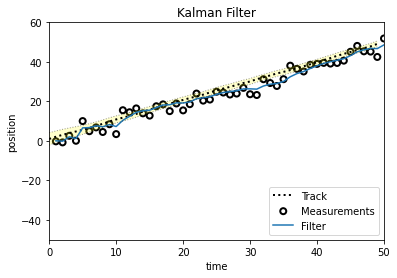

In [284]:
dt = 1.
R_var = 10
Q_var = 0.01
x = np.array([[10.0, 4.5]]).T
P = np.diag([500, 49])
F = np.array([[1, dt],
              [0,  1]])
H = np.array([[1., 0.]])
R = np.array([[R_var]])
Q = Q_discrete_white_noise(dim=2, dt=dt, var=Q_var)

from scipy.linalg import inv

count = 50
track, zs = compute_dog_data(R_var, Q_var, count)
print(track.shape,zs.shape)
xs, cov = [], []
for z in zs:
    # predict
    x = F @ x
    P = F @ P @ F.T + Q
    
    # update
    S = H @ P @ H.T + R
    K = P @ H.T @ inv(S)
    y = z - H @ x
    x += K @ y
    P = P - K @ H @ P
    
    xs.append(x)
    cov.append(P)

xs, cov = np.array(xs), np.array(cov)
plot_track(xs[:, 0], track, zs, cov, plot_P=False)